In [3]:
from PIL import Image
import torch

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "groundtruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        mask_path = os.path.join(self.root, "groundtruth", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
dataset = CellDataset('../data/augmented/', get_transform(train=True))
dataset_test = CellDataset('../data/augmented/', get_transform(train=False))

In [46]:
img, _ = dataset_test[12]

In [8]:
PATH = "../../net/entire_model_10_03_01.pt"
net = torch.load(PATH, map_location=torch.device('cpu'))

In [42]:
net.eval()
with torch.no_grad():
    prediction = net([img])

In [49]:
import random


def show_detected_masks(in_image, pred, score):
    
    in_img = in_image.mul(255).permute(1, 2, 0).byte().numpy()
    for i in range(len(pred[0]['masks'])):
        msk=pred[0]['masks'][i,0].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr>score :
            in_img[:,:,0][msk>0.5] = random.randint(0,255)
            in_img[:, :, 1][msk > 0.5] = random.randint(0,255)
            in_img[:, :, 2][msk > 0.5] = random.randint(0, 255)
    
    plt.imshow(Image.fromarray(in_image.mul(255).permute(1, 2, 0).byte().numpy()))
    plt.show()
    plt.imshow(in_img)
    plt.show()

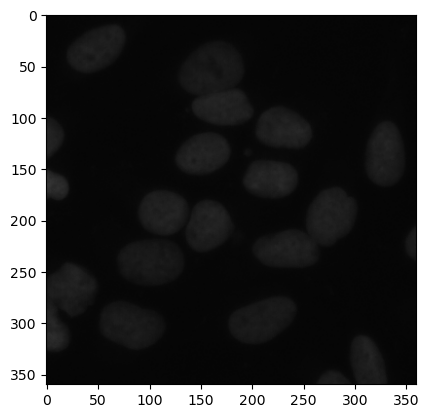

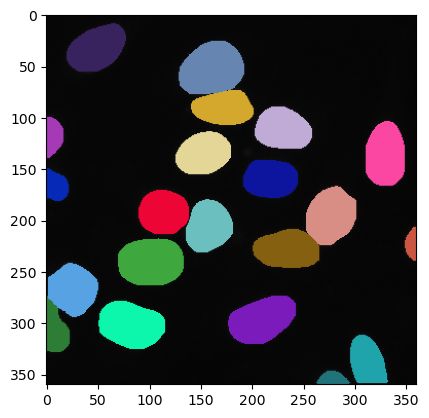

In [50]:
show_detected_masks(img, prediction, 0.8)

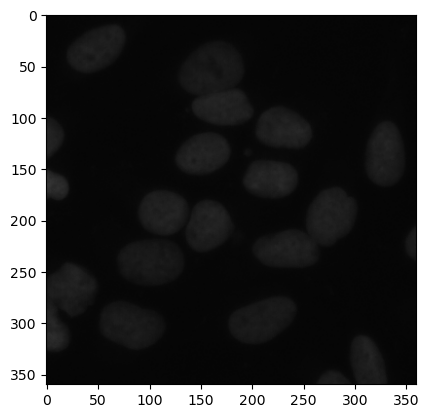

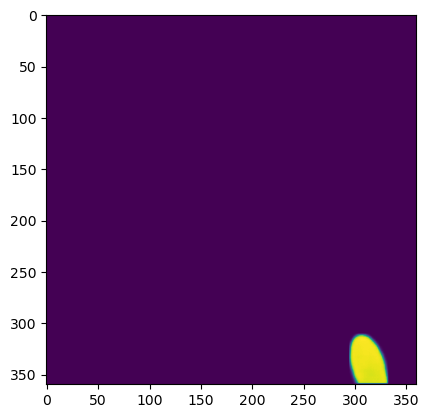

In [10]:
orig = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
predicted = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
plt.imshow(orig)
plt.show()
plt.imshow(predicted)
plt.show()


In [37]:
import cv2

pred = prediction.copy()
image = img.mul(255).permute(1, 2, 0).byte().numpy()

#im2 = image.swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)

In [29]:
im2.flags
im2.setflags(write=1)

ValueError: cannot set WRITEABLE flag to True of this array

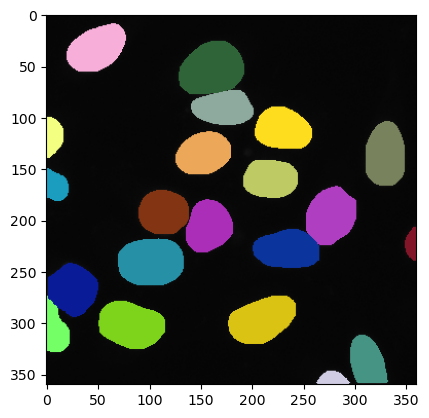

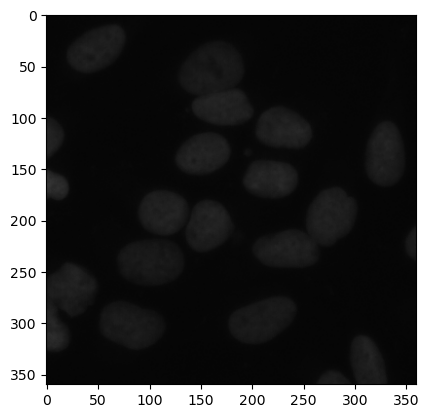

In [39]:
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.8 :
        image[:,:,0][msk>0.5] = random.randint(0,255)
        image[:, :, 1][msk > 0.5] = random.randint(0,255)
        image[:, :, 2][msk > 0.5] = random.randint(0, 255)

plt.imshow(image)
plt.show()

plt.imshow(orig)
plt.show()

In [12]:
pandas.from_dict(prediction[0])

NameError: name 'pandas' is not defined

TypeError: Invalid shape (35, 1, 360, 360) for image data

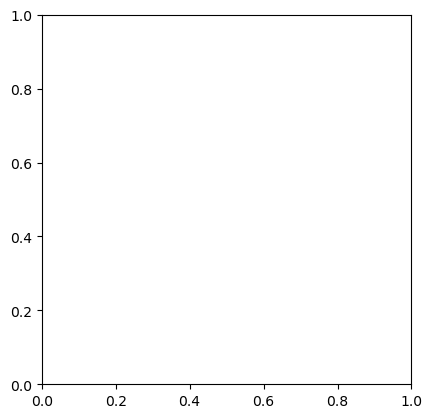

In [37]:
predict = prediction[0]['masks'].data.squeeze(0).cpu()
pd = np.array(pd)
plt.imshow(pd)

TypeError: Invalid shape (35, 1, 360, 360) for image data

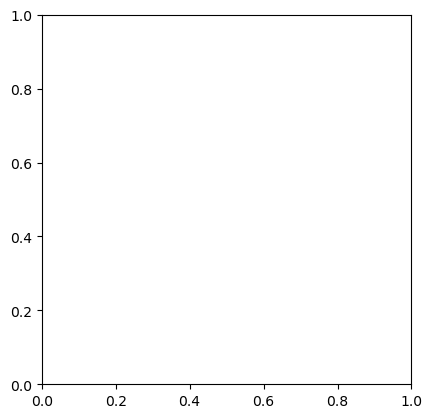

In [26]:
prediction[0]['boxes']

tensor([[2.9546e+02, 3.1218e+02, 3.3227e+02, 3.5876e+02],
        [2.0394e+02, 9.0038e+01, 2.5886e+02, 1.3066e+02],
        [2.0152e+02, 2.0897e+02, 2.6582e+02, 2.4638e+02],
        [1.2627e+02, 1.1442e+02, 1.7927e+02, 1.5607e+02],
        [1.9251e+02, 1.4206e+02, 2.4494e+02, 1.7863e+02],
        [3.1093e+02, 1.0350e+02, 3.4879e+02, 1.6668e+02],
        [1.4195e+02, 7.3270e+01, 2.0139e+02, 1.0762e+02],
        [9.6017e-01, 1.5094e+02, 2.1883e+01, 1.8101e+02],
        [2.6411e+02, 3.4653e+02, 2.9679e+02, 3.5864e+02],
        [5.8086e-01, 1.0012e+02, 1.7107e+01, 1.4024e+02],
        [3.4971e+02, 2.0654e+02, 3.5949e+02, 2.3891e+02],
        [2.6169e-01, 2.7275e+02, 2.2788e+01, 3.2850e+02],
        [2.0202e+01, 9.3806e+00, 7.7544e+01, 5.6163e+01],
        [1.3598e+02, 1.8000e+02, 1.8164e+02, 2.3133e+02],
        [1.7804e+02, 2.7455e+02, 2.4345e+02, 3.2052e+02],
        [7.0439e+01, 2.1851e+02, 1.3321e+02, 2.6391e+02],
        [5.2011e+01, 2.7899e+02, 1.1619e+02, 3.2630e+02],
        [1.298

In [23]:
prob_imgs = torch.exp(prediction[0]['masks'])
prob_imgs = prob_imgs.detach()
plt.imshow(prob_imgs.permute(1, 2, 0))


TypeError: exp(): argument 'input' (position 1) must be Tensor, not dict

In [ ]:


seg = segmentation.slic(tiger, n_segments=30, compactness=40.0, enforce_connectivity=True, sigma=3)

# Generate automatic colouring from classification labels
io.imshow(color.label2rgb(seg,tiger))
plt.show()

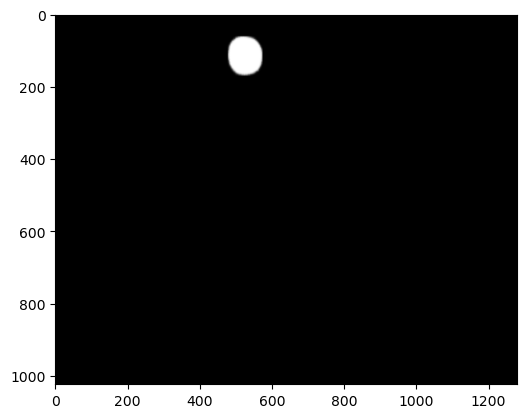

In [15]:
plt.imshow(Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy()), cmap="gray")

In [17]:
prediction[0]['masks'].shape

torch.Size([21, 1, 1024, 1280])

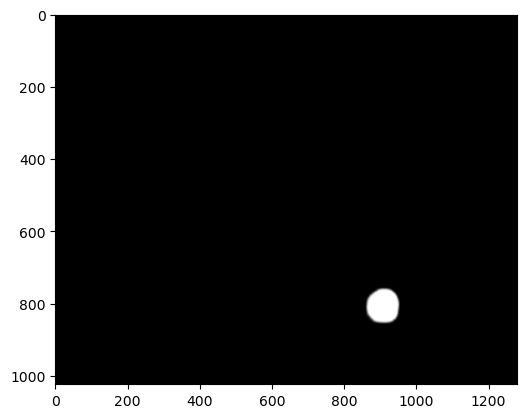

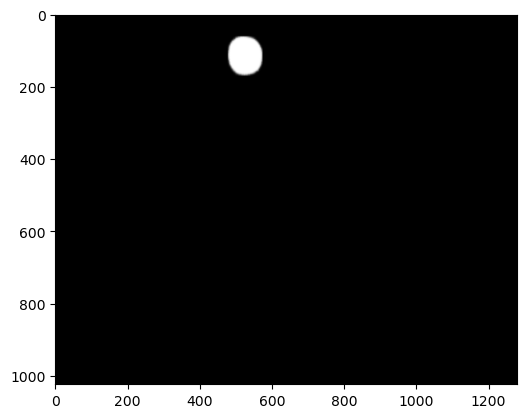

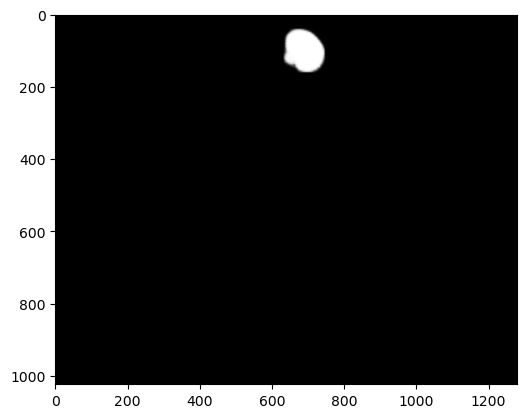

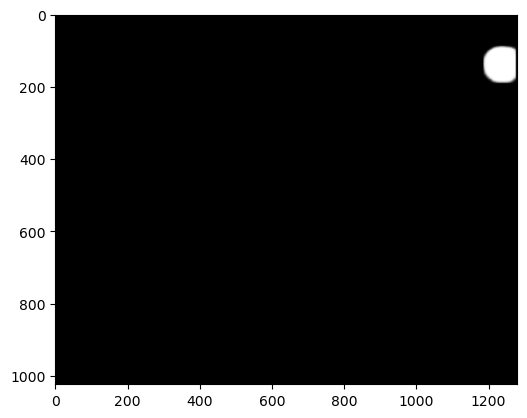

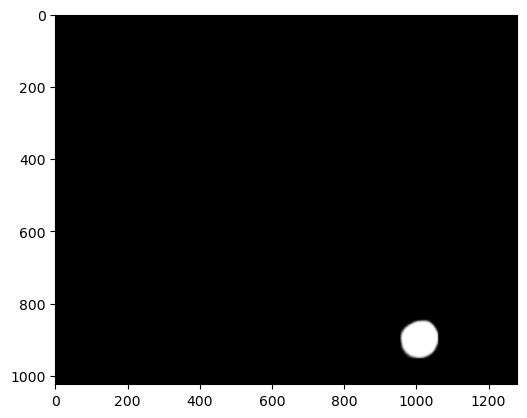

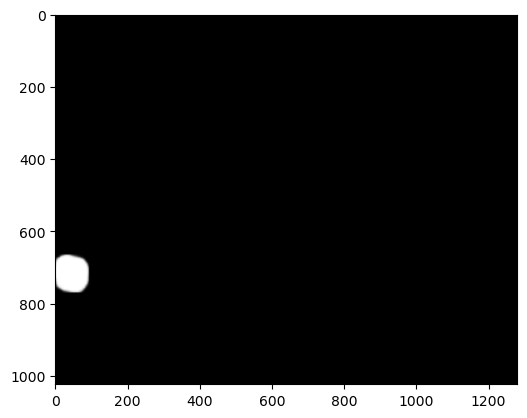

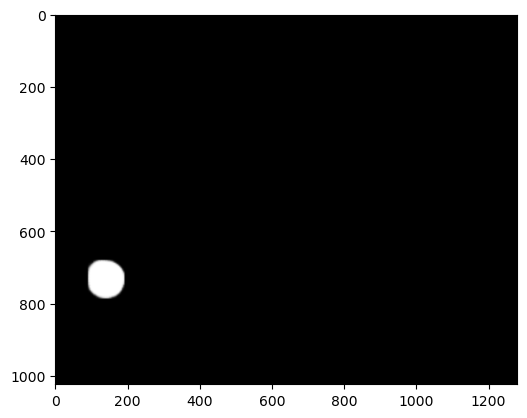

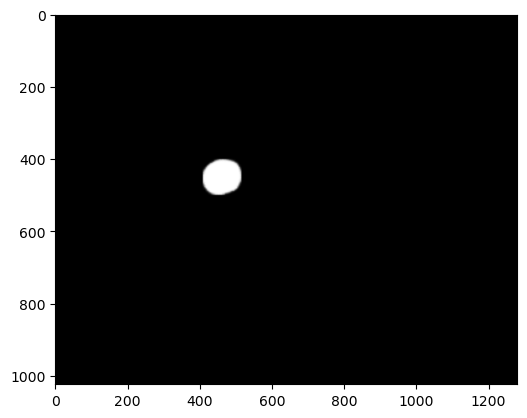

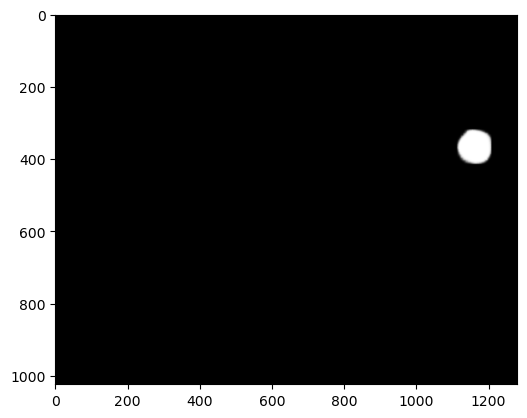

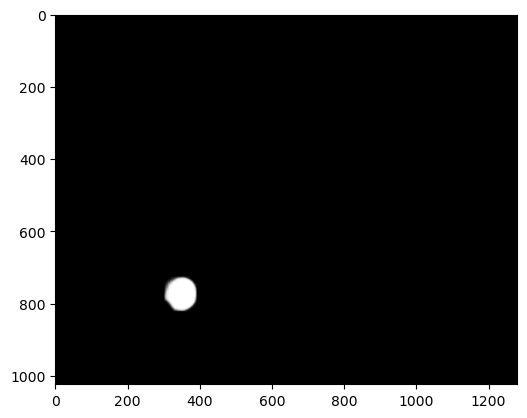

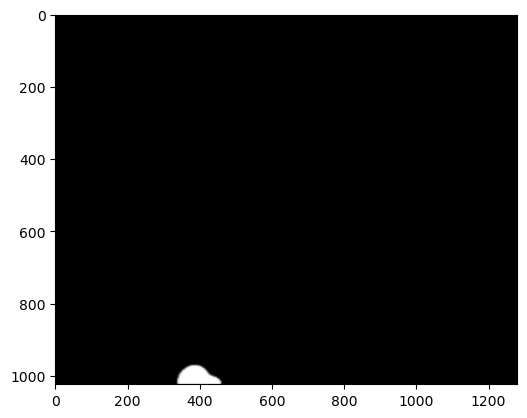

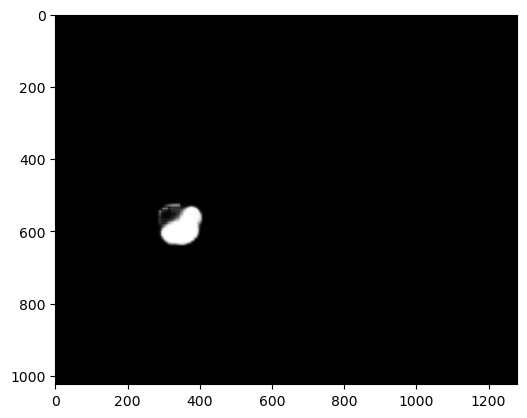

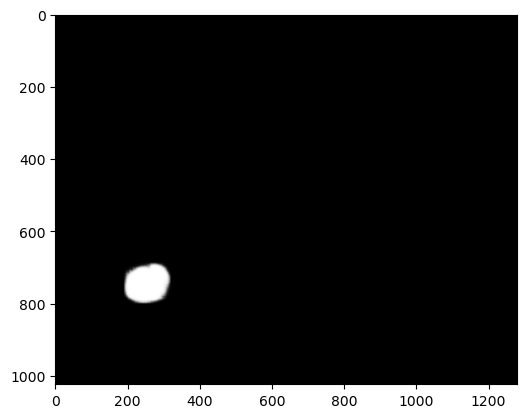

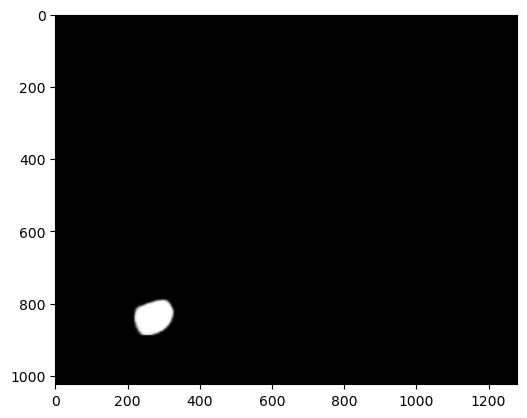

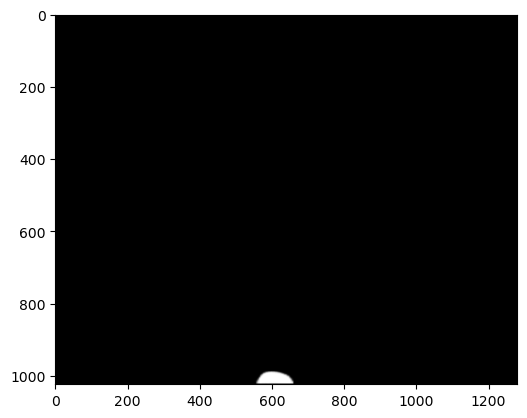

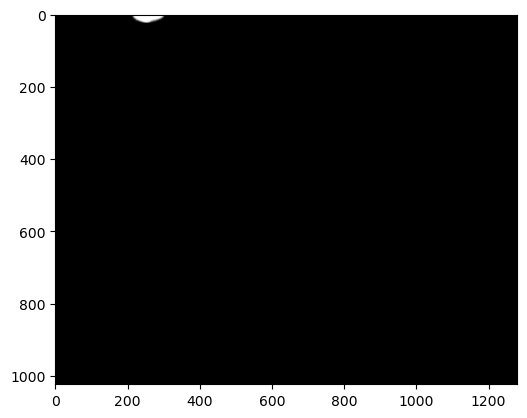

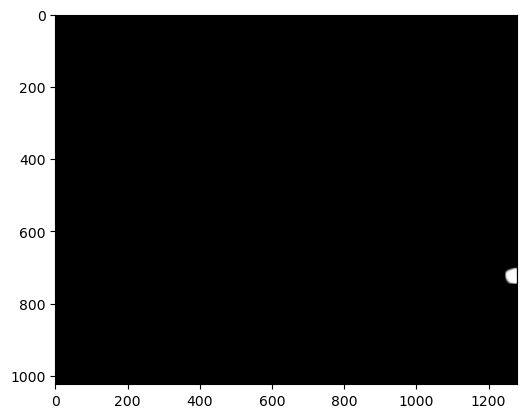

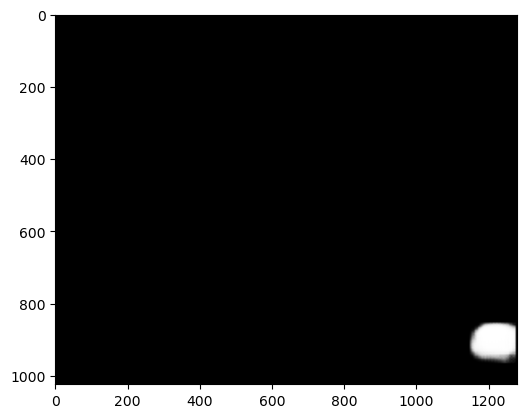

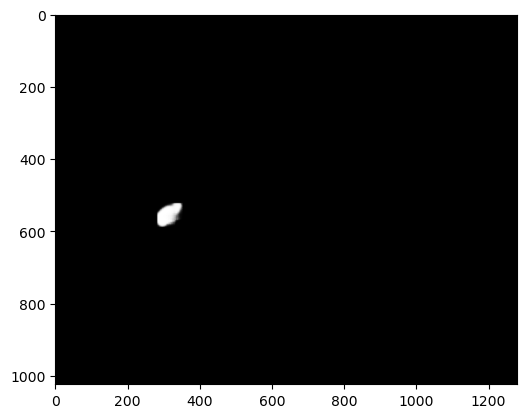

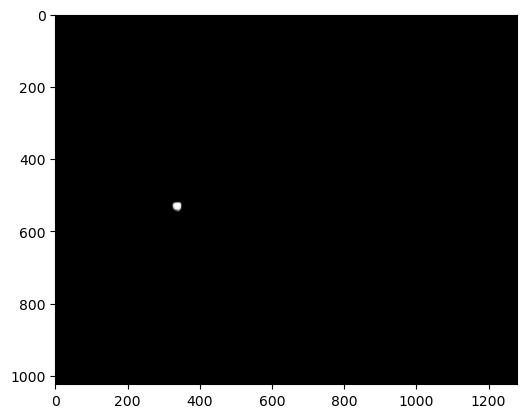

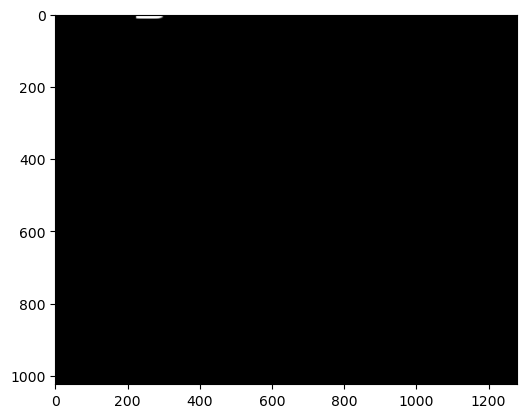

In [19]:
for i in range(21):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()), cmap="gray")
    plt.show()

In [28]:
import cv2


def load_bw_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img.convert('L'), dtype="uint8")
    return data

def get_slices(img_input, n=10, m=12):
    M = img_input.shape[0]//n
    N = img_input.shape[1]//m
    arr_of_imgs = [img_input[x:x+M, y:y+N] for x in range(0, img_input.shape[0], M) for y in range(0, img_input.shape[1], N)]
    return arr_of_imgs


def get_mask(np_img_input, minval=200, maxval=300):
    hsv_lower = np.array([minval])
    hsv_upper = np.array([maxval])
    return cv2.inRange(np_img_input, hsv_lower, hsv_upper)


def laplacian_edge_det(np_img_input, contr_scale=50):
    blur = cv2.GaussianBlur(np_img_input.astype(np.uint8), (5, 5), 0, 0)
    # scale increases the contrast
    edge_LoG = cv2.Laplacian(blur, cv2.CV_8U, 3, scale=50)
    return edge_LoG

In [29]:
IMG_PATH = '../kepek\A1.jpeg'
np_img = load_bw_image(IMG_PATH)

slices = get_slices(np_img, 10, 12)
print(len(slices))

one_slice = slices[93]
edges = laplacian_edge_det(one_slice)

mask = get_mask(edges)


143


In [37]:
m = Image.fromarray(one_slice)
m.save('./res/img/base.jpg')

In [51]:
dataset = CellDataset('./data/augmented/', get_transform(train=False))

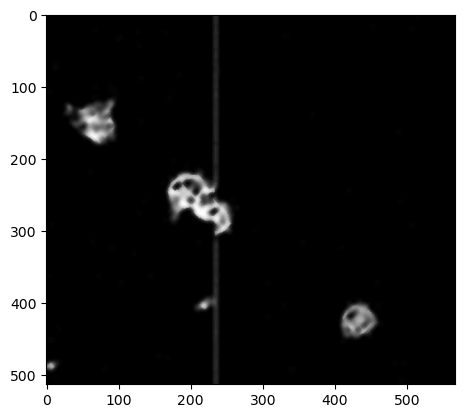

In [56]:
img, _ = dataset_test[0]
plt.imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), cmap="gray")

In [57]:
net.eval()
with torch.no_grad():
    prediction = net([img])

In [58]:
prediction[0]['masks'].shape

torch.Size([42, 1, 513, 567])

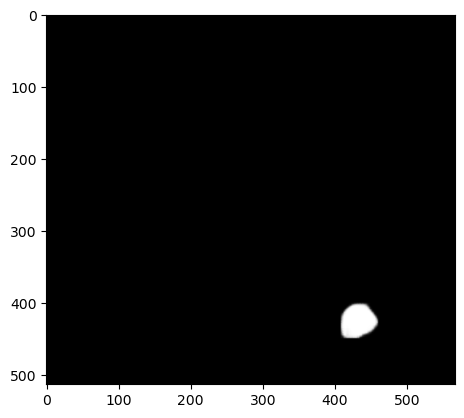

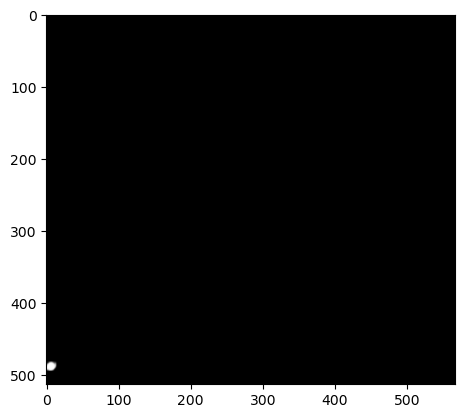

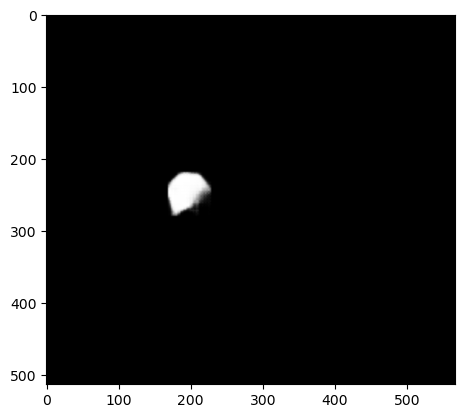

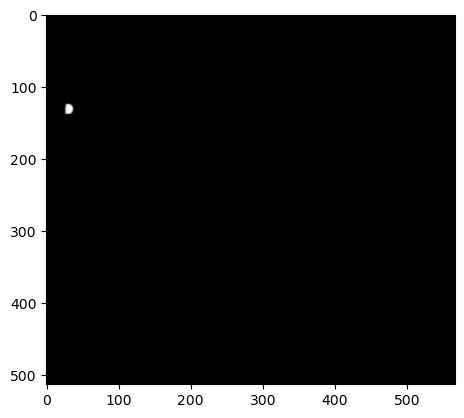

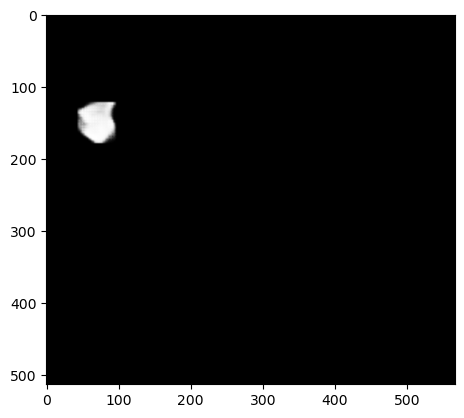

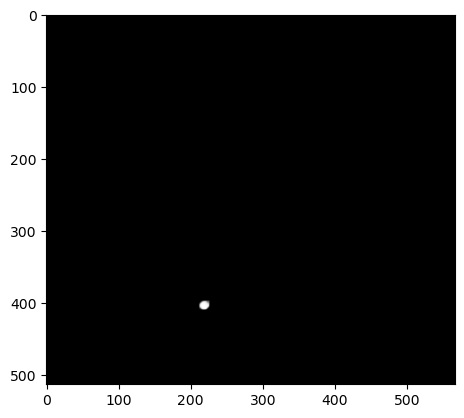

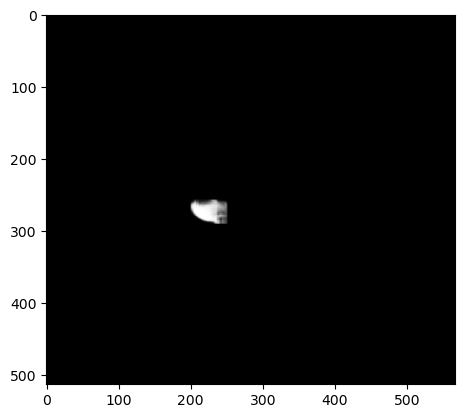

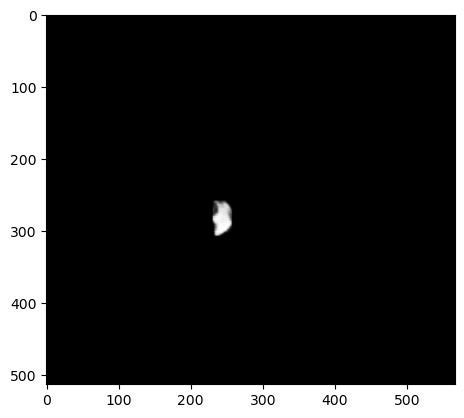

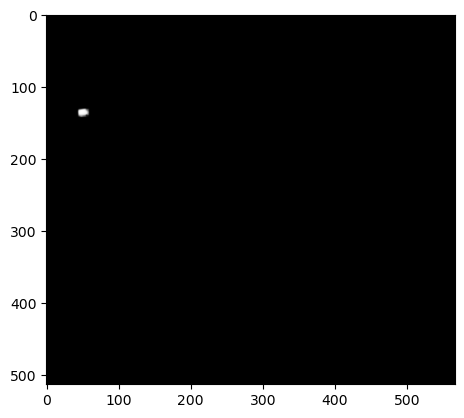

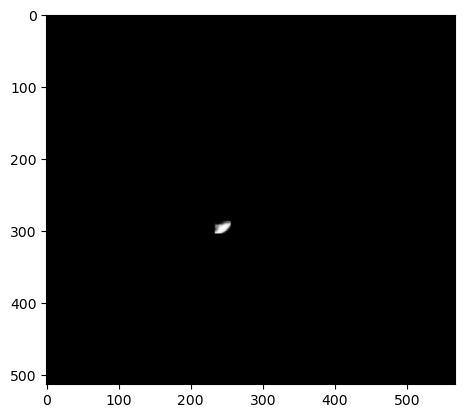

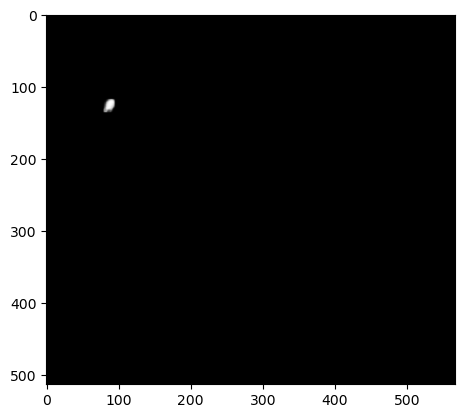

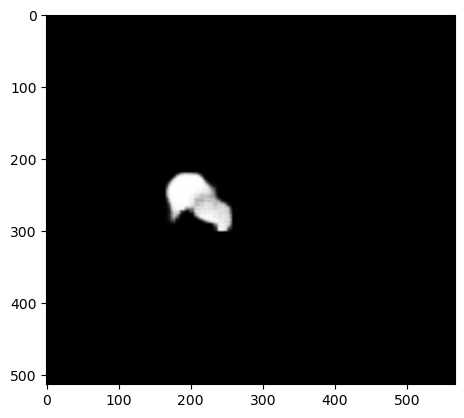

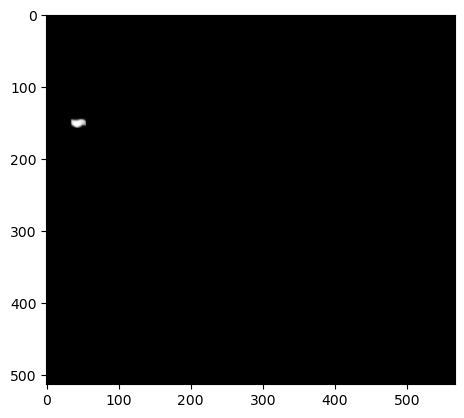

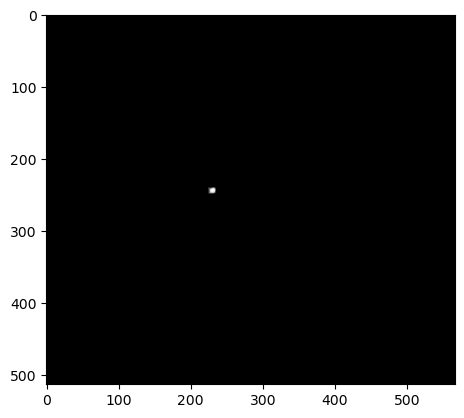

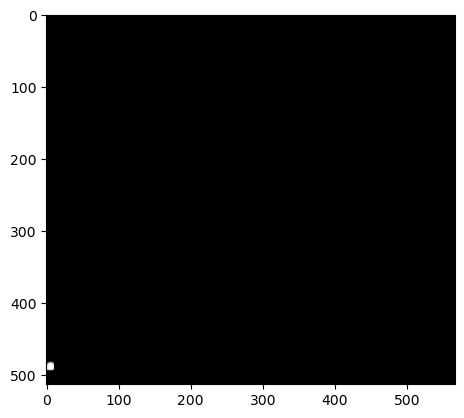

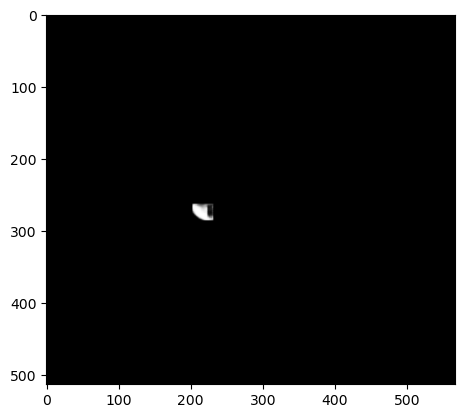

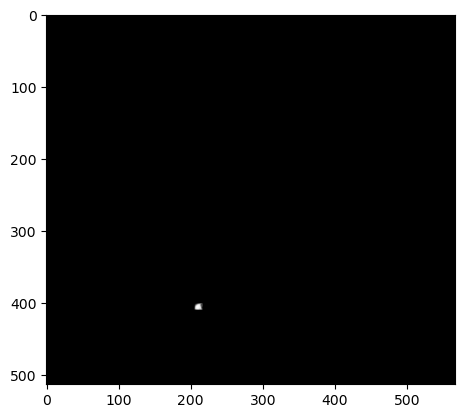

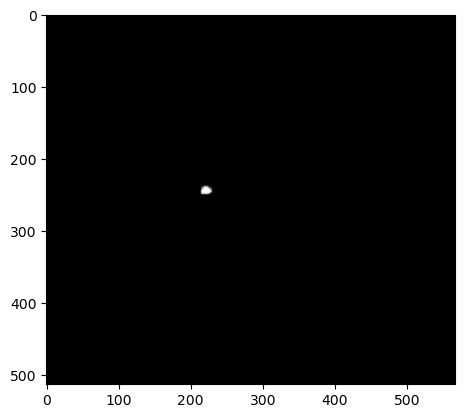

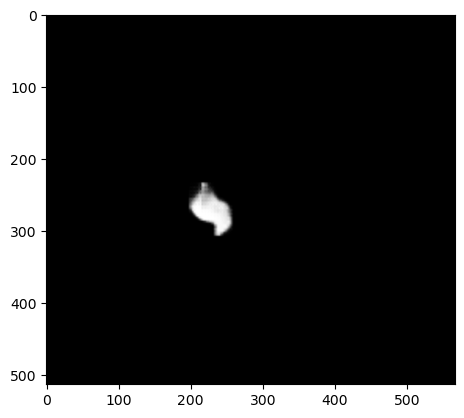

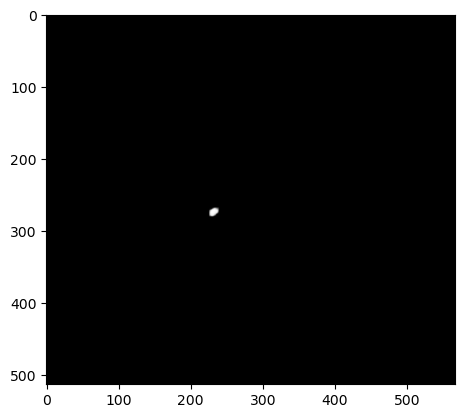

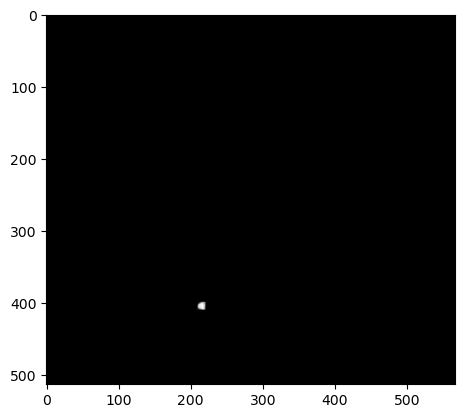

In [59]:
for i in range(21):
    plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()), cmap="gray")
    plt.show()